In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import xgboost as xgb
import shap
from shap import plots
shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
data = pd.read_csv("../data_sets/scaled_annual_data_JFE.csv")
y = data.iloc[:,2]
X = data.iloc[:,3:]
Dates = data.iloc[:,1]

In [ ]:
model = xgb.XGBRegressor(objective="reg:squarederror",
                         max_depth=3,
                         eta = 0.3,
                         colsample_bytree = 0.8,
                         subsample = 1,
                         n_estimators=150
                        ) 
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
shap_values = explainer(X)

#### SHAP time evolution

In [6]:
Dates = pd.Series(Dates, name='Dates')
df_shapley_annual = pd.concat([Dates, pd.DataFrame(shap_values.values,columns=X.columns)],axis=1)
df_shapley_annual['Dates'] = pd.to_datetime(df_shapley_annual['Dates'], format='%Y%m')

In [7]:
abs_mean_df = df_shapley_annual.groupby(df_shapley_annual['Dates'].dt.year).apply(lambda x: x.iloc[:,1:].abs().mean()).reset_index()
abs_mean_df.set_index('Dates', inplace=True)

In [8]:
abs_mean_norm_df = (abs_mean_df - abs_mean_df.min(axis=1).values.reshape(-1,1)) / (abs_mean_df.max(axis=1) - abs_mean_df.min(axis=1)).values.reshape(-1,1)
abs_mean_norm_df = abs_mean_norm_df * 100

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


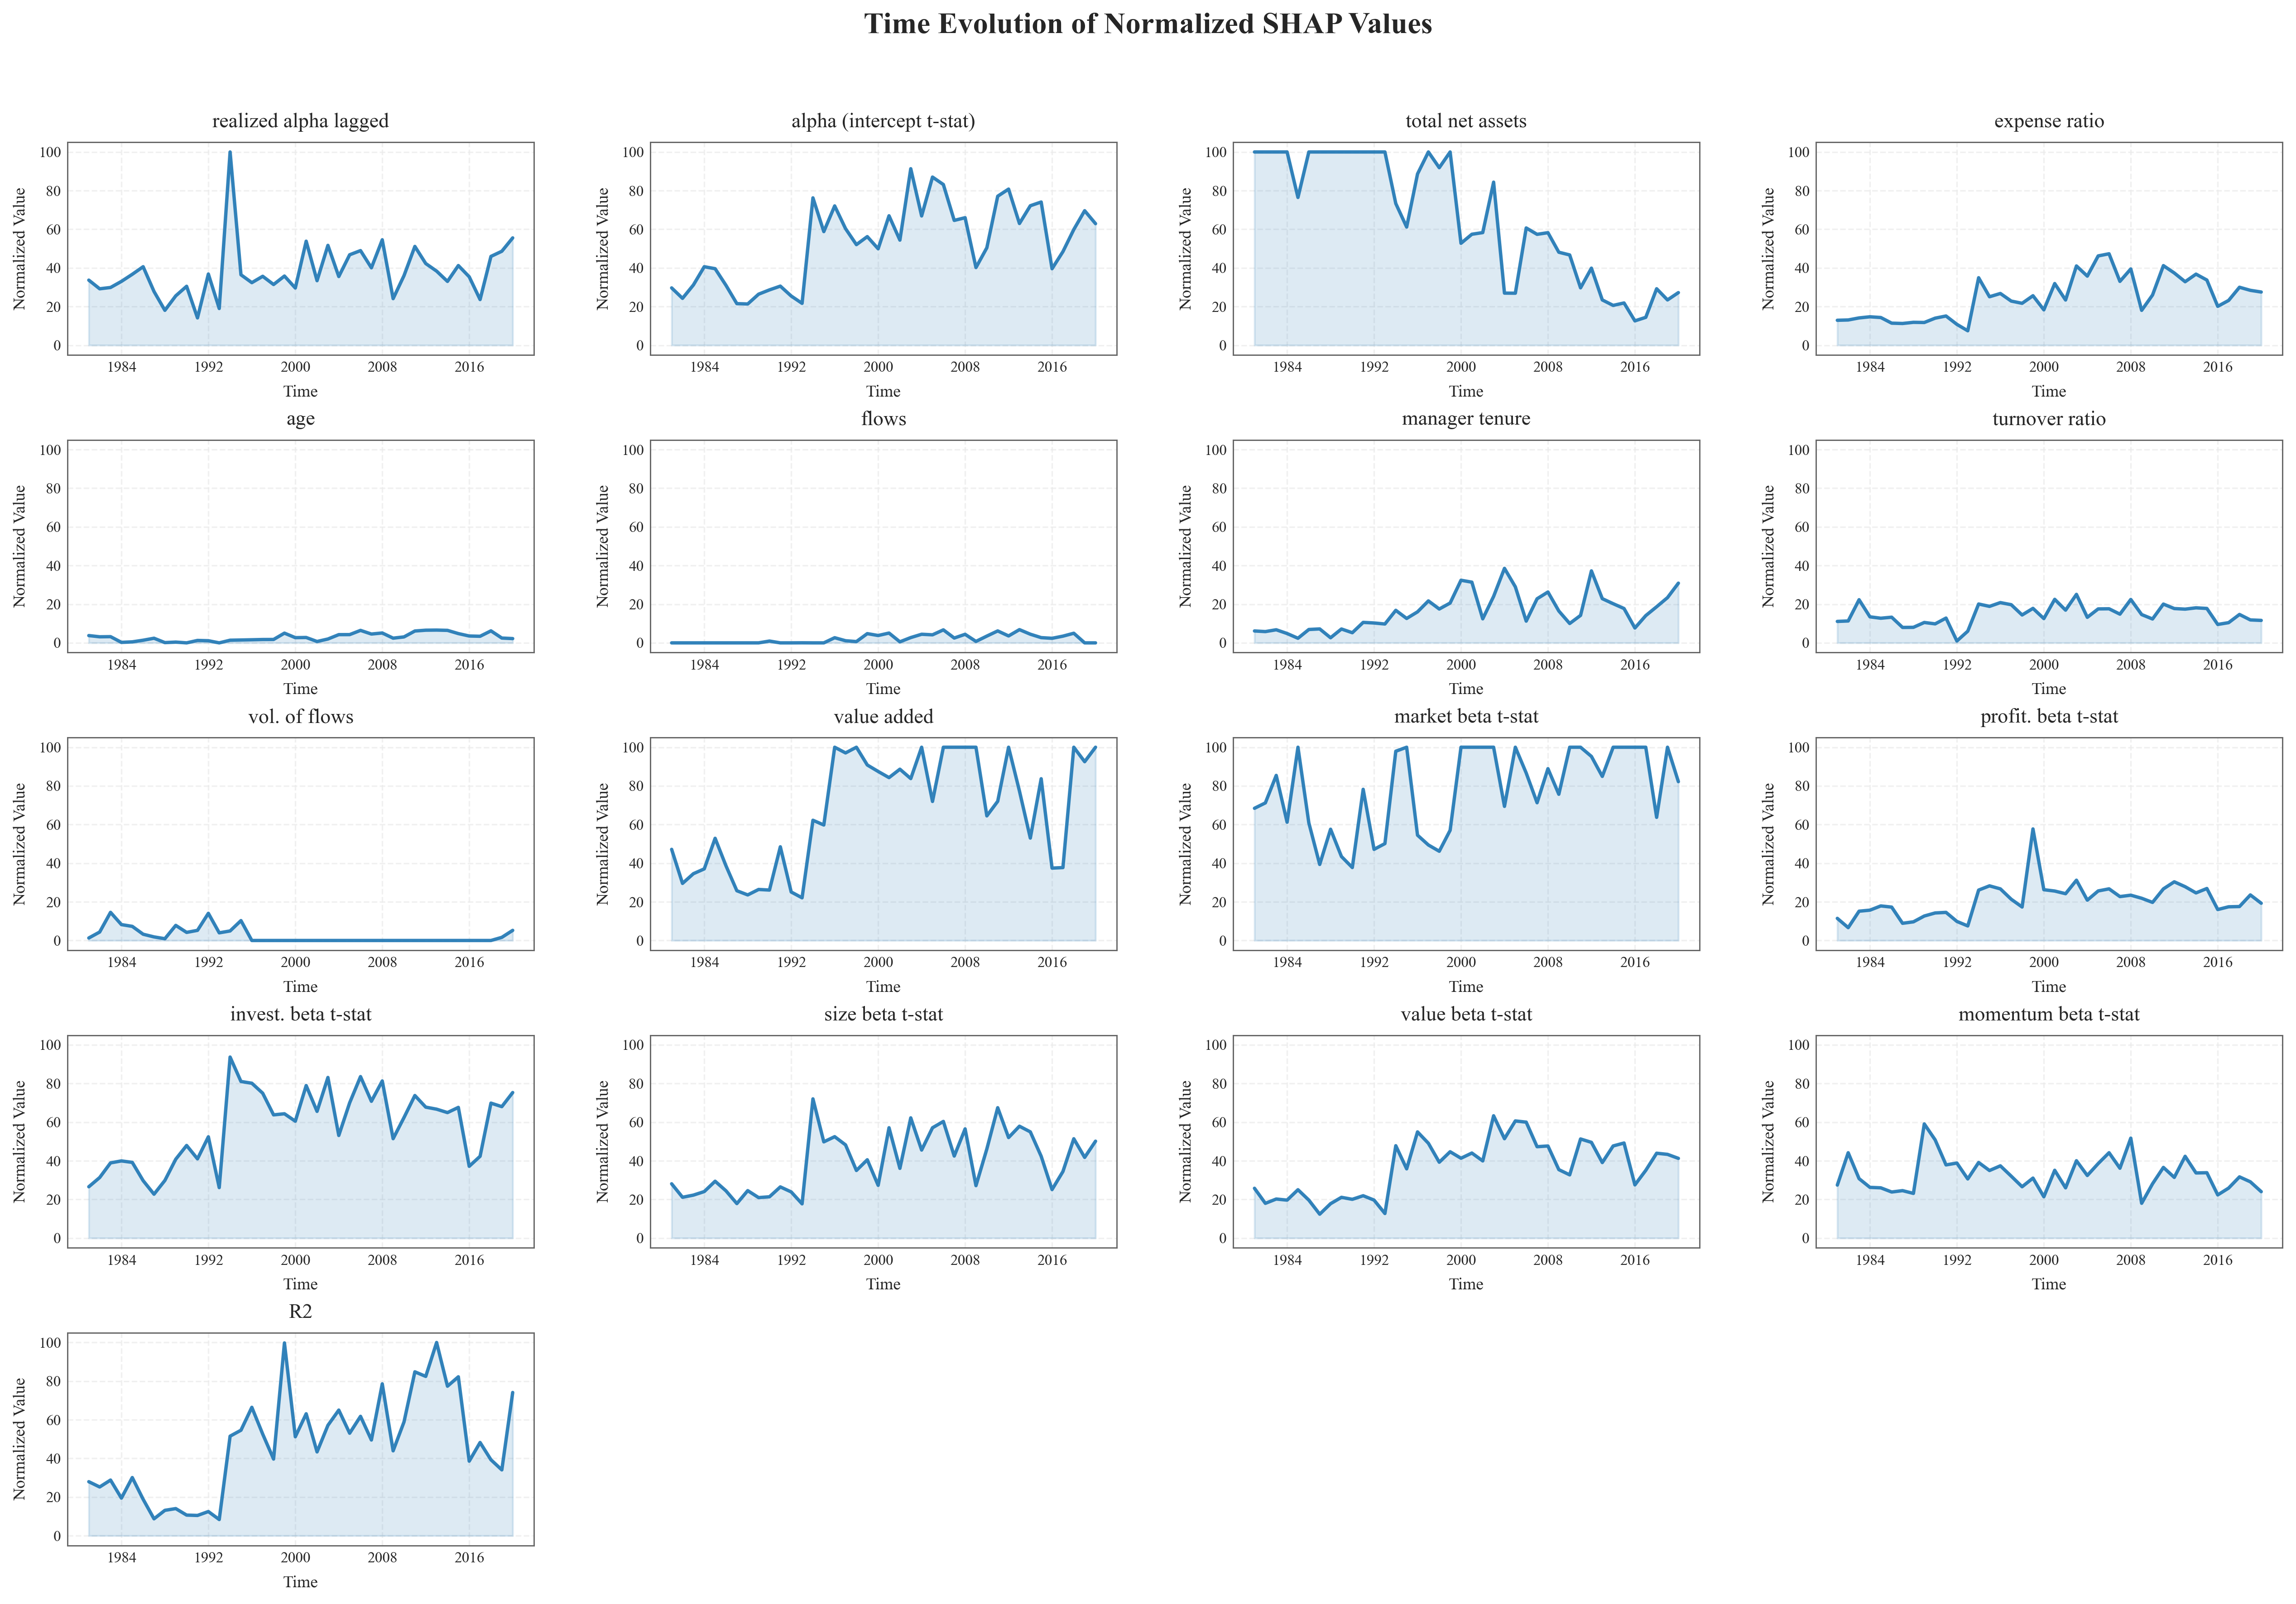

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'grid.color': '0.92',
    'grid.linestyle': '--',
    'axes.edgecolor': '0.2',
    'axes.linewidth': 0.8
})

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(17, 12), dpi=300)
axes = axes.flatten()

fig.suptitle('Time Evolution of Normalized SHAP Values', 
             fontsize=16, y=0.98, fontweight='bold')

for i, ax in enumerate(axes):
    if i < abs_mean_norm_df.shape[1]:
        line = abs_mean_norm_df.iloc[:, i].plot(
            ax=ax, 
            ylim=(-5, 105), 
            color="#1f77b4",
            linewidth=1.8,
            alpha=0.9
        )
        
        ax.fill_between(
            abs_mean_norm_df.index,
            abs_mean_norm_df.iloc[:, i],
            alpha=0.15,
            color="#1f77b4"
        )
        
        ax.set_title(
            abs_mean_norm_df.columns[i], 
            fontsize=11, 
            pad=8, 
            fontweight='medium'
        )
        ax.set_xlabel("Time", fontsize=9, labelpad=5)
        ax.set_ylabel("Normalized Value", fontsize=9, labelpad=5)
        
        ax.grid(True, linestyle='--', alpha=0.7)
        
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        ax.yaxis.set_major_locator(plt.MaxNLocator(6))
        
        for spine in ax.spines.values():
            spine.set_color('0.4')
            spine.set_linewidth(0.7)
    else:
        fig.delaxes(ax)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.4, wspace=0.25)

plt.savefig(
    "time_evolution_SHAP_GB.pdf", 
    format="pdf", 
    bbox_inches="tight",
    dpi=300,
    facecolor='white',
    edgecolor='none'
)

plt.show()